#**M3  New Taipei City Real Estate Valuation Dataset**

The data associated with this notebook can be downloaded here: https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set


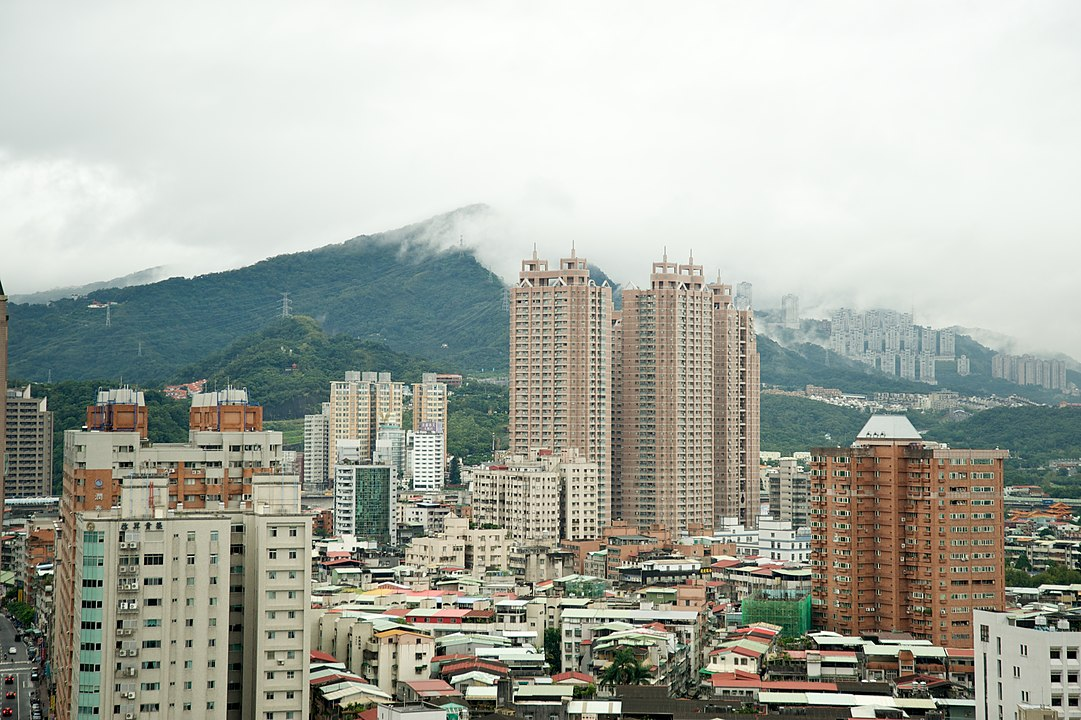

By Fred Hsu on en.wikipedia - Photo taken and uploaded by user, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=9600721

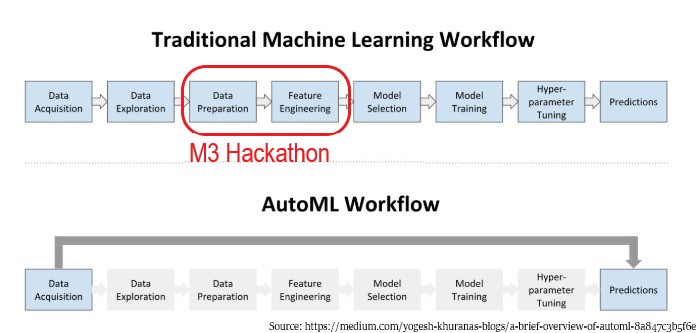

#**Table of Contents**
* Business Problem
* Executive Summary (BLUF)
* Conclusions from EDA Notebook
* Libraries
* Data
* Split Data
* Encodings
* Skewness Correction
* Outliers
* Feature Engineering: Clustering on Geography 
* Strength of Predictors
* Conclusions

#**Business Problem**
The business problem for this notebook is to execute data preprocessing requirements on the New Tapei City real estate valuation data set, and, if possible, identify strong predictors.

#**Executive Summary (BLUF)**
Skewness corrected X3_MRT (X6_Long could not be skewness corrected because of a defect in the Box Cox method)
Developed clusters for geography (latitude & longitude). Could one-hot encode the cluster labels, but did not do so here.
One-hot encoded date
PCA may not help much

#**Conclusions from EDA Notebook**
The conclusions fro the EDA notebook were as follows:

* Small dataset with skewness and outlier issues. No missing values or duplicates.
*   Need to keep as much data as possible.
*   Date of transaction and age do not appear to be important predictors.
*   The dataset may be missing key predictors such as number of rooms, community amenities, and floor of property (disclosure: I do not know much about the Xindian property market!).








#**Libraries**


In [ ]:
# Basic libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats.mstats import winsorize
import scipy.stats as ss
import math

In [ ]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
!pip install psynlig 
from psynlig import pca_explained_variance_bar
plt.style.use('seaborn-talk')

In [ ]:
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot

#**Data**
The following is adapted from https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

The market historical data set of real estate valuation were collected from Sindian Dist., New Taipei City, Taiwan. 

Attribute Information (all variables except date are quantitative):

The predictors/deatires are as follows:
- X1=the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- X2=the house age (unit: year)
- X3=the distance to the nearest MRT station (unit: meter)
- X4=the number of convenience stores in the living circle on foot (integer)
- X5=the geographic coordinate, latitude. (unit: degree)
- X6=the geographic coordinate, longitude. (unit: degree)

The real-valued target is as follows:
Y= house price of unit area (10000 New Taiwan Dollar/Ping, where Ping is a local unit, 1 Ping = 3.3 meter squared)

In [ ]:
# Read data from UCI Machine Learning Repo
file_ = "https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx"   # adapt this as needed to the file structure on your Google drive
df = pd.DataFrame(pd.read_excel(file_)) # read in csv file

In [ ]:
# Drop the index column (Column 0, "No")
if 'No' in df.columns:
  df = df.drop(["No"], axis = 1)

# The column names are verbose, so rename them (optional)
df.rename(columns = {"X1 transaction date": "X1_Date", "X2 house age": "X2_Age", "X3 distance to the nearest MRT station": "X3_MRT", "X4 number of convenience stores": "X4_Stores", "X5 latitude": "X5_Lat", "X6 longitude": "X6_Long", "Y house price of unit area": "Y_Price"},inplace = True)

# Examine the data using df.head() or df.tail()
print("HEAD of df\n", df.head()) 

HEAD of df
        X1_Date  X2_Age     X3_MRT  X4_Stores    X5_Lat    X6_Long  Y_Price
0  2012.916667    32.0   84.87882         10  24.98298  121.54024     37.9
1  2012.916667    19.5  306.59470          9  24.98034  121.53951     42.2
2  2013.583333    13.3  561.98450          5  24.98746  121.54391     47.3
3  2013.500000    13.3  561.98450          5  24.98746  121.54391     54.8
4  2012.833333     5.0  390.56840          5  24.97937  121.54245     43.1


#**Split Data**


In [ ]:
# Split Predictors
X = df.drop(['Y_Price'],axis=1)
X.head()

,X1_Date,X2_Age,X3_MRT,X4_Stores,X5_Lat,X6_Long
0,2012.916667,32.0,84.87882,10,24.98298,121.54024
1,2012.916667,19.5,306.59470,9,24.98034,121.53951
2,2013.583333,13.3,561.98450,5,24.98746,121.54391
3,2013.500000,13.3,561.98450,5,24.98746,121.54391
4,2012.833333,5.0,390.56840,5,24.97937,121.54245


#**Encodings**

In [ ]:
# We could one-hot encode the date (since there are relatively few dates) in the hope it boosts regressor performance
# Uncomment this code cell to examine this
# if 'X1_Date' in df.columns:
#   dates = pd.get_dummies(df['X1_Date'], prefix='X1_')
#   df = df.drop(["X1_Date"], axis = 1)
#   df=pd.concat([dates,df],axis=1)
# df.head()


#**Skewness Correction**

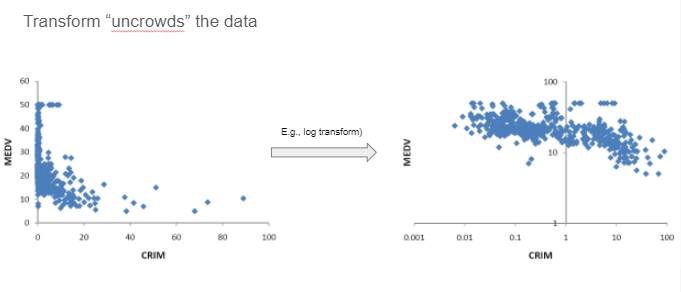

In [ ]:
# Code for skewness correction (see source below)
# Depending upon the characteritics of a feature (column), a log, Box-Cox or power transform is applied to normalize the distribution 

# -*- coding: utf-8 -*-
"""

"""

##################################################
# A function that will accept a pandas dataframe
# and auto-transforms columns that exceeds threshold value
#  -  Offers choice between boxcox or log / exponential transformation
#  -  Automatically handles negative values
#  -  Auto recognizes positive /negative skewness


def skew_autotransform(DF, include = None, exclude = None, plot = False, threshold = 1, exp = False):
    
    #Get list of column names that should be processed based on input parameters
    if include is None and exclude is None:
        colnames = DF.columns.values
    elif include is not None:
        colnames = include
    elif exclude is not None:
        colnames = [item for item in list(DF.columns.values) if item not in exclude]
    else:
        print('No columns to process!')
    
    #Helper function that checks if all values are positive
    def make_positive(series):
        minimum = np.amin(series)
        #If minimum is negative, offset all values by a constant to move all values to positive teritory
        if minimum <= 0:
            series = series + abs(minimum) + 0.01
        return series
    
    
    #Go through desired columns in DataFrame
    for col in colnames:
        #Get column skewness
        skew = DF[col].skew()
        transformed = True
        
        if plot:
            #Prep the plot of original data
            sns.set_style("darkgrid")
            sns.set_palette("Blues_r")
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            #ax1 = sns.distplot(DF[col], ax=axes[0])
            ax1 = sns.histplot(DF[col], ax=axes[0], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
            ax1.set(xlabel='Original ' + str(col))
        
        #If skewness is larger than threshold and positively skewed; If yes, apply appropriate transformation
        if abs(skew) > threshold and skew > 0:
            skewType = 'positive'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply log transformation 
               DF[col] = DF[col].apply(math.log)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
         
        elif abs(skew) > threshold and skew < 0:
            skewType = 'negative'
            #Make sure all values are positive
            DF[col] = make_positive(DF[col])
            
            if exp:
               #Apply exp transformation 
               DF[col] = DF[col].pow(10)
            else:
                #Apply boxcox transformation
                DF[col] = ss.boxcox(DF[col])[0]
            skew_new = DF[col].skew()
        
        else:
            #Flag if no transformation was performed
            transformed = False
            skew_new = skew
        
        #Compare before and after if plot is True
        if plot:
            print('\n ------------------------------------------------------')     
            if transformed:
                print('\n %r had %r skewness of %2.2f' %(col, skewType, skew))
                print('\n Transformation yielded skewness of %2.2f' %(skew_new))
                sns.set_palette("Paired")
                #ax2 = sns.distplot(DF[col], ax=axes[1], color = 'r')
                ax2 = sns.histplot(DF[col], ax=axes[1], color="red", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='Transformed ' + str(col))
                plt.show()
            else:
                print('\n NO TRANSFORMATION APPLIED FOR %r . Skewness = %2.2f' %(col, skew))
                #ax2 = sns.distplot(DF[col], ax=axes[1])
                ax2 = sns.histplot(DF[col], ax=axes[1], color="blue", label="100% Equities", kde=True, stat="density", linewidth=0)
                ax2.set(xlabel='NO TRANSFORM ' + str(col))
                plt.show()
    return DF


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'X2_Age' . Skewness = 0.38


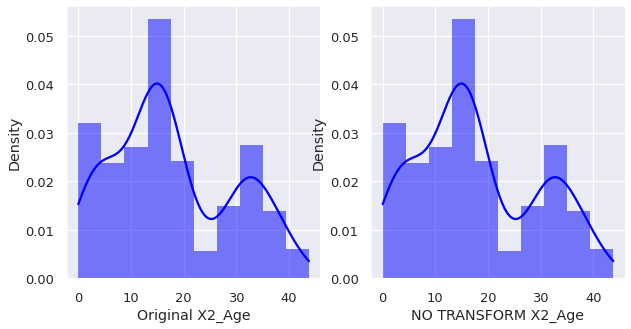


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'X3_MRT' . Skewness = 0.00


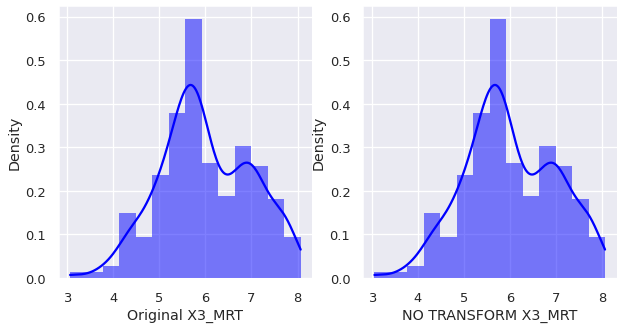


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'X4_Stores' . Skewness = 0.15


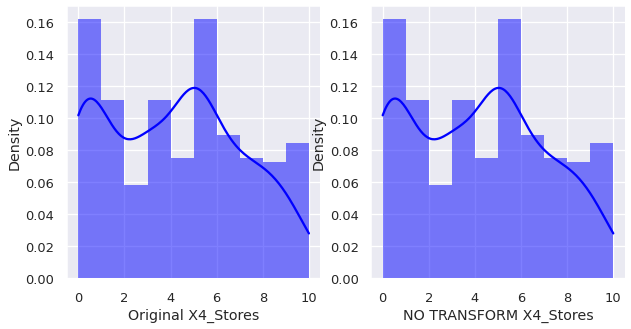

In [ ]:
# Use code above (adapted from https://github.com/datamadness/Automatic-skewness-transformation-for-Pandas-DataFrame) to correct skewness
X = skew_autotransform(X.copy(deep=True), include=['X2_Age', 'X3_MRT', 'X4_Stores'],plot = True, exp = False, threshold = 1)

# It's not clear how to handle X5 and X6. Skew correcting them would lose our ability to infer distance 
# So I will avoid skew correcting them, and instead do some feature engineering with them using clustering

#**Outliers**
Detection:
* z-Scores
* Box plots, violin plots or scatter diagrams for univariate outliers. A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. See [this](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51#:~:text=A%20boxplot%20is%20a%20standardized,and%20what%20their%20values%20are.) for more.
* Parallel coordinates plot for multivariate outliers. Parallel coordinates plots allow the comparison of multiple features at once, which each feature plotted on a vertical axis that has a unique scale. 

Possible actions to account for outliers:
* Do nothing	
* Deletion (multivariate outliers?)
* Cap values by winsorizing
* Transform (log, power, inverse, etc)
* More sophisticated contextual methods for univariate outliers

Notes:
* Some ML algorithms are highly susceptible to outliers (e.g., multiple linear regression, and kNN)
* Some ML algorithms require (or do better with) normalized attributes , e.g., linear regression, logistic regression, SVM, kNN, and some neural networks. 
* Normalizing attributes with outliers may lead to a concentration of the data in a small subinterval of [0,1]
* **Tukey's Rule**: values below Q1-1.5 IQR or above Q3+1.5 IQR, where Q1 and Q3 are the first and third quartiles, respectively, and IQR is the interquartile range (Q3-Q1). The same limits are obtained using Q2 $\pm$ 2IQR
* **Winsorizing**: see https://en.wikipedia.org/wiki/Winsorizing





In [ ]:
# Unvariate Outliers: 
cols = X.columns
for i in range(12,len(cols)):
  print("Column ",X.columns[i])
  ax = sns.boxplot(data=X.iloc[:,i], orient="h", palette="Set2")
  plt.show()

# No outliers for X3_MRT. X4_Stores has one outlier (but it's reasonable at 2 store).
# Many latitude and longitude outliers identified. Handle these using clustering as they are geographical


#**Feature Engineering: Clustering on Geography**

In [ ]:
X

,X1_Date,X2_Age,X3_MRT,X4_Stores,X5_Lat,X6_Long
0,2012.916667,32.0,4.254555,10,24.98298,121.54024
1,2012.916667,19.5,5.417820,9,24.98034,121.53951
2,2013.583333,13.3,5.956639,5,24.98746,121.54391
3,2013.500000,13.3,5.956639,5,24.98746,121.54391
4,2012.833333,5.0,5.633841,5,24.97937,121.54245
...,...,...,...,...,...,...
409,2013.000000,13.7,7.676042,0,24.94155,121.50381
410,2012.666667,5.6,4.312885,9,24.97433,121.54310
411,2013.250000,18.8,5.634755,7,24.97923,121.53986
412,2013.000000,8.1,4.447605,5,24.96674,121.54067


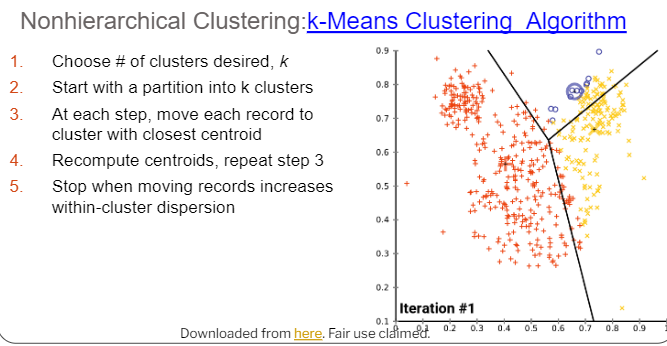

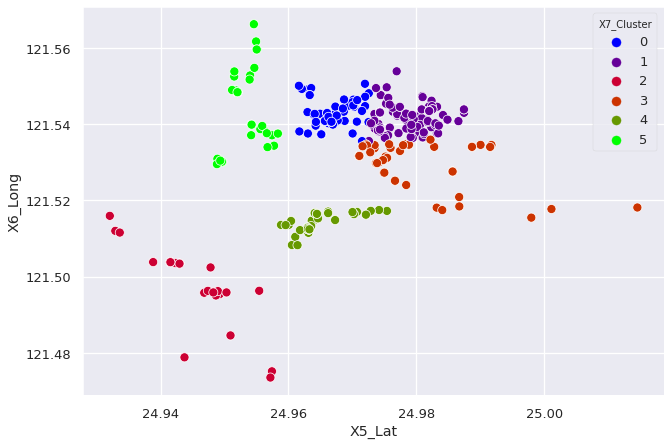

In [ ]:
# k-means clustering
# define the model
model = KMeans(n_clusters=6)
# fit the model
model.fit(X[['X5_Lat','X6_Long']])
# assign a cluster to each example
yhat = pd.DataFrame(model.predict(X[['X5_Lat','X6_Long']]),columns=['X7_Cluster'])
if 'X7_Cluster' not in X:
  X = pd.concat([X,yhat],axis=1)
else:
  X['X7_Cluster'] = yhat
colors = ['#747FE3', '#8EE35D', '#E37346']
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x='X5_Lat', y='X6_Long', data=X, hue='X7_Cluster', palette = "brg")


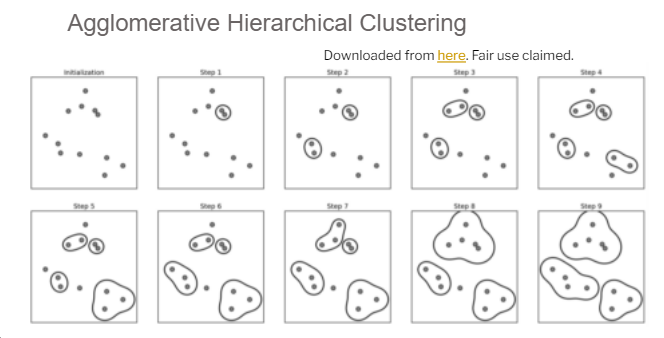

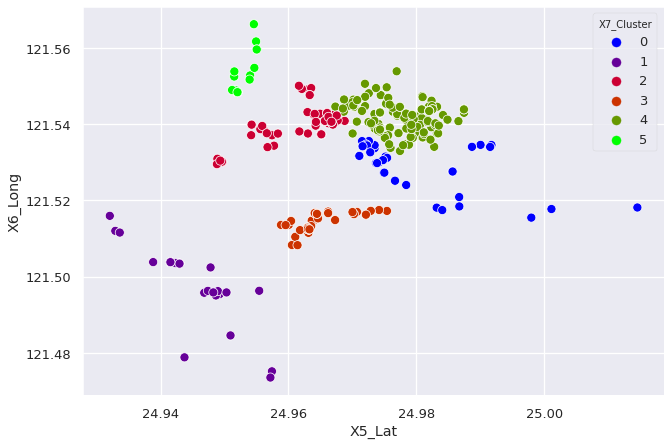

In [ ]:
# Agglomerative Clustering
model = AgglomerativeClustering(n_clusters=6)
model.fit(X[['X5_Lat','X6_Long']])
# assign a cluster to each example
yhat = pd.DataFrame(model.fit_predict(X[['X5_Lat','X6_Long']]),columns=['X7_Cluster'])
if 'X7_Cluster' not in X:
  X = pd.concat([X,yhat],axis=1)
else:
  X['X7_Cluster'] = yhat
colors = ['#747FE3', '#8EE35D', '#E37346']
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x='X5_Lat', y='X6_Long', data=X, hue='X7_Cluster', palette = "brg")

#**Strength of Predictors**

##*Pairplot*

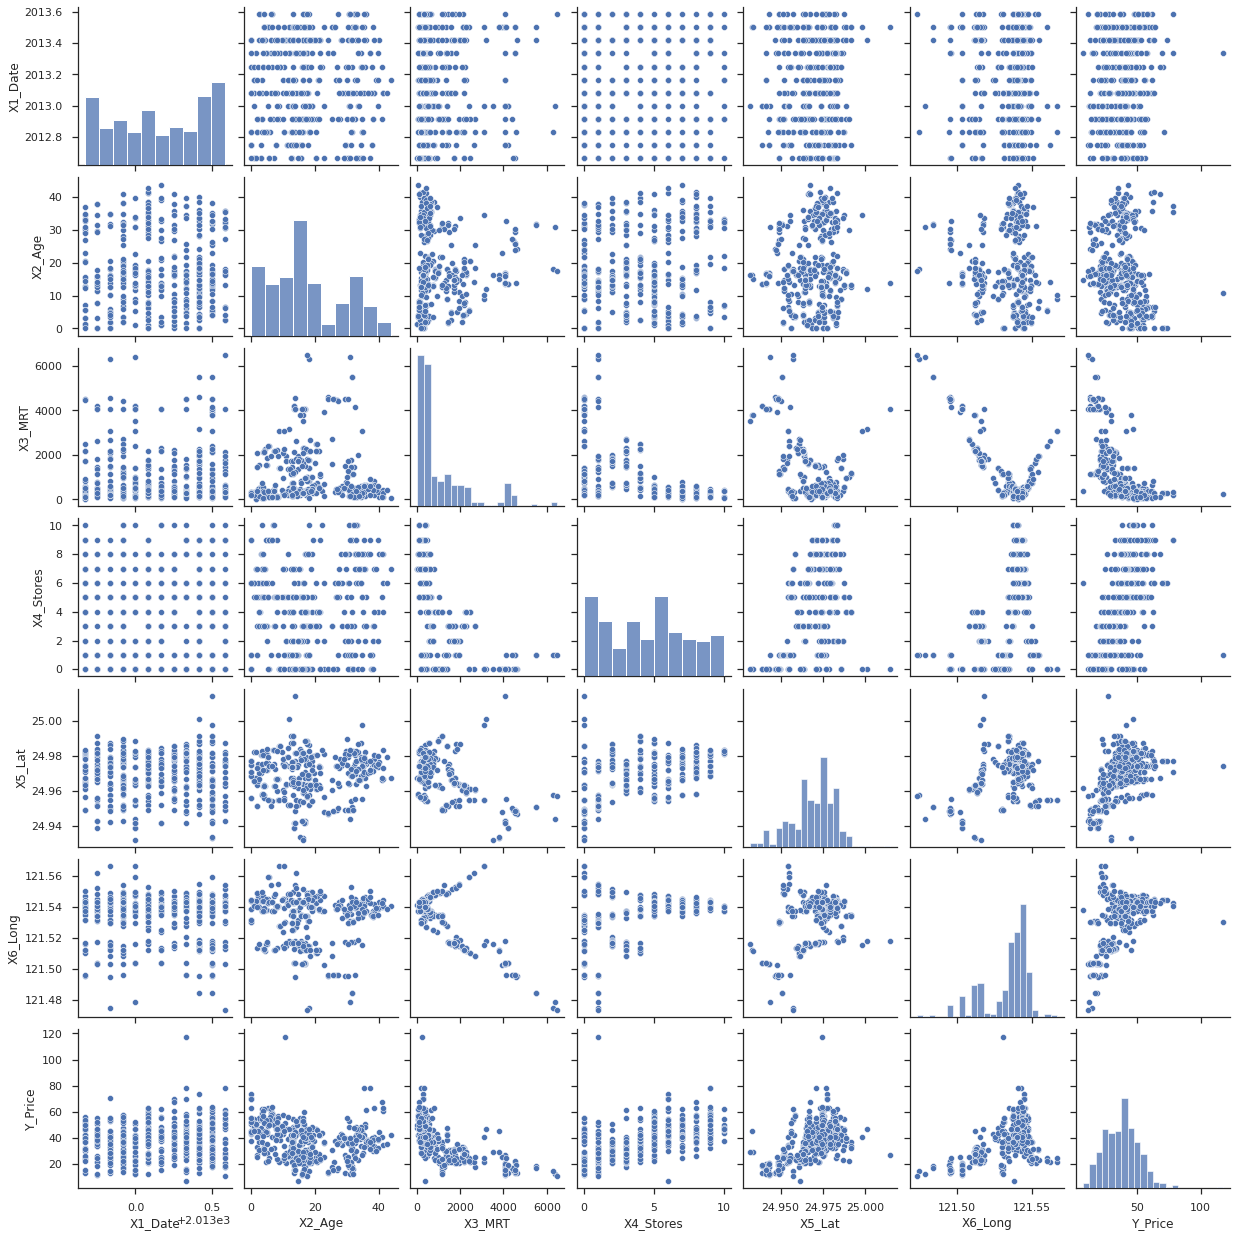

In [ ]:
# Bivariate Graphical Descriptive Statistics
#Scatterplot matrix - these can take some time to gerenerate if the number of features is large
sns.set_theme(style="ticks")
sns.pairplot(df)

# Outliers noticeable (one in particular)

In [ ]:
# Bringing features onto the same scale：normalization and standardization:

# Min-max scaling(Normalization) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

mms = MinMaxScaler()
X_norm = mms.fit_transform(X)

# Standardization z-score  (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
# from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()  
X_std = stdsc.fit_transform(X)

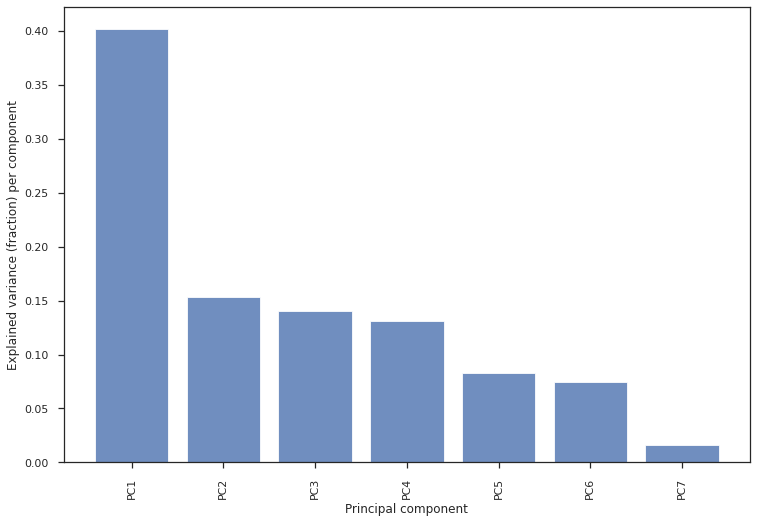

In [ ]:
# Principal Components Analysis
# Examine the explained variance ratio in order for each components
pca = PCA()
X_pca = pca.fit_transform(X_std)
pca.explained_variance_ratio_

pca_explained_variance_bar(pca, alpha=0.8)
plt.show()


#**Conclusions**

- Skewness corrected X3_MRT (X6_Long could not be skewness corrected because of a defect in the Box Cox method)
- Developed clusters for geography (latitude & longitude). Could one-hot encode the cluster labels, but did not do so here.
- One-hot encoded date
- PCA may not help much


